In [1]:
"""Take biowulf produced temporal generalization data stacked from BiowulfWithinStillStack.ipynb
and plot the temporal generalization"""

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
top_dir = '/Users/sm6511/Desktop/NIH_Experiment/Bids/derivatives/'
output_dir = os.path.join(top_dir, 'Plots')
data_dir = os.path.join(top_dir, 'Processed_Data/TempGenWithinStill/data')
peak_dir = os.path.join(top_dir, 'Processed_Data/LDA-16way Static/Mean') #Location of csv with peak times in decoding
times_dir = os.path.join(top_dir, 'Processed_Data/times') #Files containing objects with timepoints in trials for plotting
file_path = os.path.join(data_dir, 'allSubjects_trainTime_data.npy')
file_path_times = os.path.join(times_dir, 'TimesForPlots.npy')
all_subjects_data = np.load(file_path)
times = np.load(file_path_times)
# Paths
print(output_dir)

# Load peak time information
df = pd.read_csv(os.path.join(peak_dir, 'Peak_Times.csv'))

row_all = df.loc[df['Subject'] == 'all']
time1_sample = int(row_all['peak1_sample'].values[0])
time2_sample = int(row_all['peak2_sample'].values[0])
time1 = row_all['peak1_time_ms'].values[0]
time2 = row_all['peak2_time_ms'].values[0]




/Users/sm6511/Desktop/NIH_Experiment/Bids/derivatives/Plots


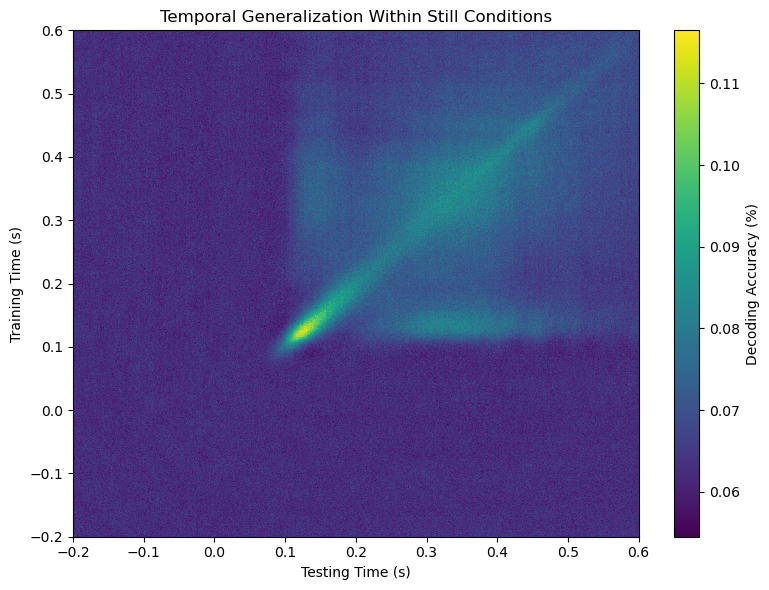

In [2]:
#Iniital Visualization of Temporal Generalization averaged across subjects

import matplotlib.pyplot as plt
import numpy as np
mean_accuracy = np.mean(all_subjects_data, axis=0)  # shape: (train_times, test_times)
times = np.load(file_path_times)

#Plot
plt.figure(figsize=(8, 6))
im = plt.imshow(mean_accuracy, 
                origin='lower',   
                aspect='auto', 
                interpolation='nearest', 
                cmap='viridis',
                extent=[times[0], times[-1], times[0], times[-1]])  # ← try 'inferno' or 'magma' too!

plt.colorbar(im, label='Decoding Accuracy (%)')
plt.xlabel('Testing Time (s)')
plt.ylabel('Training Time (s)')
plt.title('Temporal Generalization Within Still Conditions')
plt.tight_layout()
plt.show()
plt.close()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from matplotlib.colors import LogNorm

'''Run BF Analysis on tempgen plot '''

# R setup (library paths may need to be adjusted based on environment)
conversion.set_conversion(default_converter + pandas2ri.converter)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")
print("R packages loaded successfully.")

# Parameters
chance = 1 / 16
mu = 0
nullMin = 0.5
nullMax = float('inf')
rscale = 'medium'
start_time = -0.2
end_time = 0.6
n_timepoints = 961
times = np.linspace(start_time, end_time, n_timepoints)


# Load all subjects
def load_tempgen_data(data_dir):
    subject_mats = []
    subject_ids = []
    for subj_num in range(1, 21):  # S01–S20
        subj = f"S{subj_num:02d}"
        file_path = os.path.join(data_dir, f"{subj}_trainTime_data.npy")
        if os.path.exists(file_path):
            mat = np.load(file_path)
            subject_mats.append(mat)
            subject_ids.append(subj)
    subject_mats = np.array(subject_mats)  # shape (n_subjects, train, test)
    print(f"Loaded {len(subject_ids)} subjects with shape {subject_mats.shape}")
    return subject_mats, subject_ids

data_all, subject_ids = load_tempgen_data(data_dir)

# Compute Bayes Factors matrix
def compute_bayes_factors_tempgen(data_all):
    """
    Compute BF for each [train, test] pair across subjects.
    data_all: shape (n_subjects, train_time, test_time)
    """
    n_subjects, n_train, n_test = data_all.shape
    bf_matrix = np.zeros((n_train, n_test))

    # normalize by chance
    normalized = data_all - chance

    print("Computing Bayes Factors")
    for i in range(n_train):
        if i % 100 == 0:
            print(f"Training time {i}/{n_train}")
        for j in range(n_test):
            # Data across subjects for one train/test time pair
            sample_data = normalized[:, i, j]
            df = pd.DataFrame({'x': sample_data})

            with localconverter(ro.default_converter + pandas2ri.converter):
                r_vector = ro.conversion.py2rpy(df['x'])

            result = bayesfactor.ttestBF(
                x=r_vector,
                mu=mu,
                rscale=rscale,
                nullInterval=ro.FloatVector([nullMin, nullMax])
            )

            bf_value = np.array(ro.r['as.vector'](result))[0]
            bf_matrix[i, j] = bf_value

    return bf_matrix

bf_matrix = compute_bayes_factors_tempgen(data_all)

# Compute group mean accuracy 
mean_tempgen = data_all.mean(axis=0)

# Save results   
np.save(os.path.join(data_dir, "BF_matrix.npy"), bf_matrix)



R packages loaded successfully.
Loaded 20 subjects with shape (20, 961, 961)
Computing Bayes Factors
Training time 0/961


Exception ignored from cffi callback <function _processevents at 0x17f6184a0>:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/mne2_arm/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 308, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


Loaded 20 subjects with shape (20, 961, 961)
[[-2.22717778 -2.07551938 -2.0920621  ... -2.36909763 -3.72889703
  -2.82031782]
 [-3.49540453  0.11108786  0.49009021 ... -1.63754862  0.05556514
  -2.46032081]
 [-2.86342411 -0.99933014  1.01055127 ... -1.29841592  0.73596492
  -1.40994106]
 ...
 [-1.50111845 -0.11948397 -4.31740164 ...  1.8794397   1.67837784
   1.77596519]
 [-2.56877326 -0.63845776 -1.04429374 ...  1.52827229  1.1628592
   0.27138987]
 [-2.91504286 -1.19685672 -2.41880441 ...  1.05151154  1.02455943
   1.50043729]]


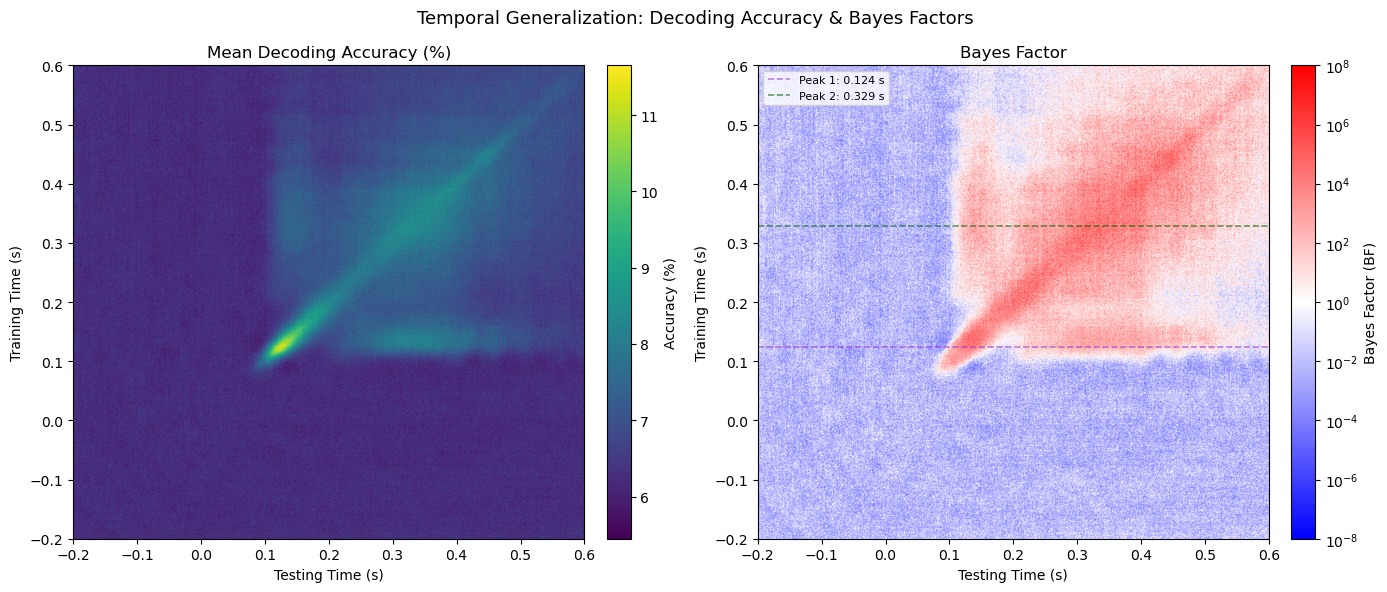

Plot saved to /Users/sm6511/Desktop/NIH_Experiment/Bids/derivatives/Plots/Figure1d_TempGen_BF_Analysis.png


In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def load_tempgen_data(data_dir):
    subject_mats = []
    subject_ids = []
    for subj_num in range(1, 21):  # S01–S20
        subj = f"S{subj_num:02d}"
        file_path = os.path.join(data_dir, f"{subj}_trainTime_data.npy")
        if os.path.exists(file_path):
            mat = np.load(file_path)
            subject_mats.append(mat)
            subject_ids.append(subj)
    subject_mats = np.array(subject_mats)  # shape (n_subjects, train, test)
    print(f"Loaded {len(subject_ids)} subjects with shape {subject_mats.shape}")
    return subject_mats, subject_ids

data_all, subject_ids = load_tempgen_data(data_dir)
bf_matrix = np.load(os.path.join(data_dir, "BF_matrix.npy"))
mean_tempgen = data_all.mean(axis=0)

def plot_bf_tempgen(mean_mat, bf_mat, times, save_dir):
    log_bf = np.log10(bf_mat)
    print(log_bf)
    vmin, vmax = -8, 8
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Mean decoding accuracy
    im1 = ax1.imshow(mean_mat * 100, origin='lower', 
                     extent=[times[0], times[-1], times[0], times[-1]],
                     cmap='viridis', aspect='auto')
    ax1.set_title('Mean Decoding Accuracy (%)')
    ax1.set_xlabel('Testing Time (s)')
    ax1.set_ylabel('Training Time (s)')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Accuracy (%)')

    # Bayes Factor
    im2 = ax2.imshow(log_bf, origin='lower', 
                     extent=[times[0], times[-1], times[0], times[-1]],
                     cmap='bwr', norm=norm, aspect='auto')
    ax2.set_title('Bayes Factor')
    ax2.set_xlabel('Testing Time (s)')
    ax2.set_ylabel('Training Time (s)')
    ax2.axhline(
    y=time1/1000, color='darkorchid', linestyle='--', alpha=0.6, linewidth=1.2,
    label=f"Peak 1: {time1/1000:.3f} s"
)

    ax2.axhline(
    y=time2/1000, color='darkgreen', linestyle='--', alpha=0.6, linewidth=1.2,
    label=f"Peak 2: {time2/1000:.3f} s"
)

    ax2.legend(loc="upper left", fontsize=8, frameon=True)


    # Custom colorbar labels as 10^x 
    cbar = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    ticks = np.arange(vmin, vmax + 1, 2)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"$10^{{{int(t)}}}$" for t in ticks])
    cbar.set_label('Bayes Factor (BF)', fontsize=10)
    fig.suptitle('Temporal Generalization: Decoding Accuracy & Bayes Factors', fontsize=13)
    plt.tight_layout()
    save_path = os.path.join(output_dir, 'Figure1d_TempGen_BF_Analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print(f"Plot saved to {save_path}")



plot_bf_tempgen(mean_tempgen, bf_matrix, times, output_dir)

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_4278/2926328789.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdBu', 3)


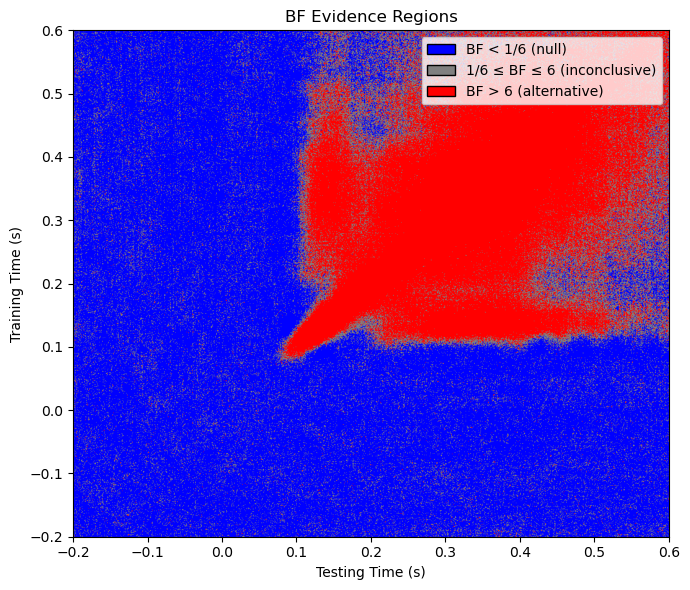

Plot saved to /Users/sm6511/Desktop/NIH_Experiment/Bids/derivatives/Plots/Extras/Tempgen_Threshold/BF_thresholded.png


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bf_thresholded(bf_mat, times, save_dir):
    # Define thresholds
    lower = 1/6
    upper = 6
    
    # 0 = evidence for null (BF < 1/6)
    # 1 = inconclusive (1/6 <= BF <= 6)
    # 2 = evidence for alternative (BF > 6)
    mask = np.zeros_like(bf_mat)
    mask[bf_mat > upper] = 2
    mask[(bf_mat >= lower) & (bf_mat <= upper)] = 1
    mask[bf_mat < lower] = 0

    # Define colors for each region
    cmap = plt.cm.get_cmap('RdBu', 3) 
    colors = ['blue', 'gray', 'red']   # null, inconclusive, alternative
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(mask, origin='lower', 
                   extent=[times[0], times[-1], times[0], times[-1]],
                   cmap=cmap, aspect='auto')
    
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('BF Evidence Regions')

    # Add custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', edgecolor='k', label='BF < 1/6 (null)'),
        Patch(facecolor='gray', edgecolor='k', label='1/6 ≤ BF ≤ 6 (inconclusive)'),
        Patch(facecolor='red', edgecolor='k', label='BF > 6 (alternative)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    folder = os.path.join(output_dir, 'Extras', 'Tempgen_Threshold')
    os.makedirs(folder, exist_ok=True)

    # Then build file path
    save_path = os.path.join(folder, 'BF_thresholded.png')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {save_path}")

plot_bf_thresholded(bf_matrix, times, output_dir)


Peak 1 sample: 389, Peak 2 sample: 635


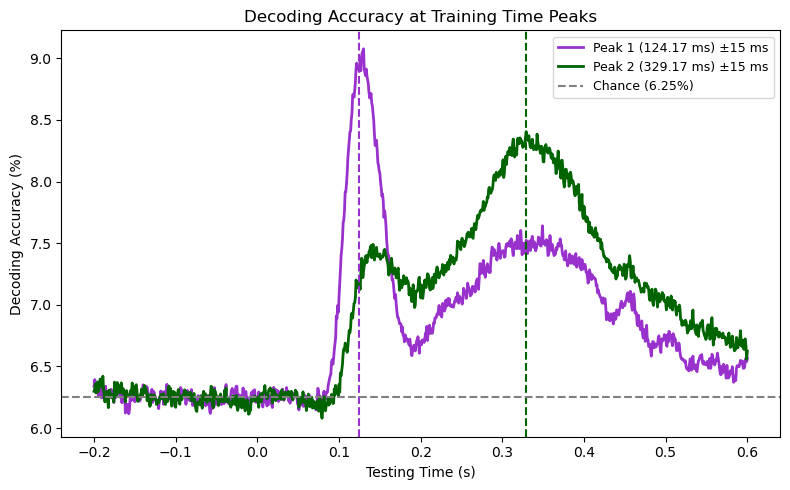

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Training window function
def get_train_window(peak_sample, window_size=36):
    """
    Return a window (start, end) of samples centered on the peak_sample.
    """
    start = max(0, peak_sample - window_size)
    end = peak_sample + window_size
    return start, end



print(f"Peak 1 sample: {time1_sample}, Peak 2 sample: {time2_sample}")

# Compute mean accuracy across subjects
mean_accuracy = np.mean(all_subjects_data, axis=0)  # shape: [train_time, test_time]

# Get windows around each peak
win1_start, win1_end = get_train_window(time1_sample, window_size=36)
win2_start, win2_end = get_train_window(time2_sample, window_size=36)

# compute mean across window (averaging over training times within window)
line_peak1 = mean_accuracy[win1_start:win1_end, :].mean(axis=0) * 100  # Convert to %
line_peak2 = mean_accuracy[win2_start:win2_end, :].mean(axis=0) * 100  # Convert to %

# Plot
plt.figure(figsize=(8, 5))
plt.plot(times, line_peak1, color='darkorchid', linewidth=2, label=f'Peak 1 ({time1:.2f} ms) ±15 ms')
plt.plot(times, line_peak2, color='darkgreen', linewidth=2, label=f'Peak 2 ({time2:.2f} ms) ±15 ms')
plt.axvline(time1/1000, color='darkorchid', linestyle='--')
plt.axvline(time2/1000, color='darkgreen', linestyle='--')

# Chance level in %
chance = (1/16) * 100
plt.axhline(chance, color='gray', linestyle='--', label=f'Chance ({chance:.2f}%)')

plt.xlabel('Testing Time (s)')
plt.ylabel('Decoding Accuracy (%)')
plt.title('Decoding Accuracy at Training Time Peaks')
plt.legend(fontsize = 9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Figure1e_DecodingAccuracy_PeakLines.png'), dpi=300)
plt.show()


OLD STUFF BELOW

In [10]:
import numpy as np
import os

base_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/TempGenWithinStill/data'
subject_ids = [f"S{str(i).zfill(2)}" for i in range(1, 21)]  # adjust number of subjects


train_idx = time1_sample
train_idx2 = time2_sample

all_subjects_line = []

for subj in subject_ids:
    if subj == "S09":  # skip subject 9
        continue
    data = np.load(os.path.join(base_path, f"{subj}_trainTime_data.npy"))  # shape: train_times x test_times
    line = data[train_idx, :]  # extract row for that training time
    all_subjects_line.append(line)

all_subjects_line = np.array(all_subjects_line)  # shape: subjects x test_times
print(all_subjects_line.shape)

all_subjects_line2 = []

for subj in subject_ids:
    if subj == "S09":  # skip subject 9
        continue
    data = np.load(os.path.join(base_path, f"{subj}_trainTime_data.npy"))  # shape: train_times x test_times
    line = data[train_idx2, :]  # extract row for that training time
    all_subjects_line2.append(line)

all_subjects_line2 = np.array(all_subjects_line2)  # shape: subjects x test_times
print(all_subjects_line2.shape)


(19, 961)
(19, 961)


 R packages loaded successfully.


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_57575/3849339135.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


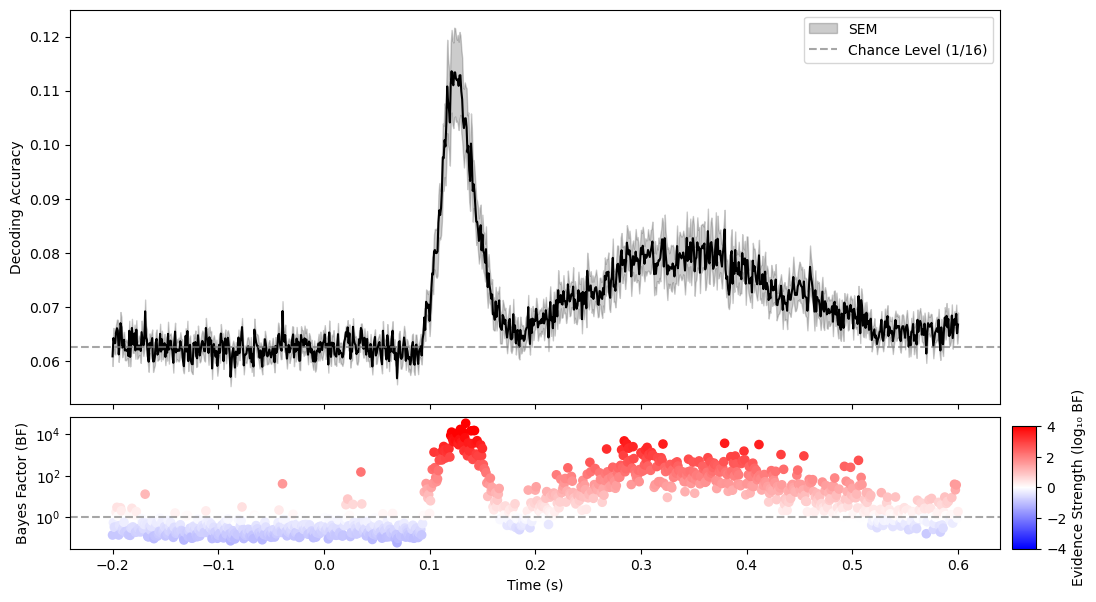

In [6]:
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#Library path to r (will need to be adjusted for a given environment)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)
#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # <-- wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)

bf_line = compute_bayes_factors_group(all_subjects_line)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

log_bf = np.log10(bf_line)
times = np.load('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy')

# Colormap setup
cmap = cm.get_cmap('bwr')
max_abs_logbf = 4
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_logbf, vcenter=0, vmax=max_abs_logbf)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

# Top plot: mean decoding accuracy
sem_scores = all_subjects_line.std(axis=0) / np.sqrt(all_subjects_line.shape[0])
ax1.plot(times, all_subjects_line.mean(axis=0), color='black')
ax1.fill_between(times, all_subjects_line.mean(axis=0) - sem_scores, all_subjects_line.mean(axis=0) + sem_scores,
                 color='black', alpha=0.2, label='SEM')
ax1.axhline(y=1/16, color='gray', linestyle='--', label='Chance Level (1/16)', alpha=.7)
ax1.set_ylabel('Decoding Accuracy')
ax1.legend(loc='upper right')

# Bottom plot: Bayes Factor dots
sc = ax2.scatter(times, bf_line, c=log_bf, cmap=cmap, norm=norm, s=35)
ax2.set_yscale('log')
ax2.set_ylabel('Bayes Factor (BF)')
ax2.axhline(y=1, color='gray', linestyle='--', label='BF = 1', alpha=.7)
ax2.set_xlabel('Time (s)')  # x-axis now in seconds




# Colorbar
pos = ax2.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
sc.set_clim(-max_abs_logbf, max_abs_logbf)
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Evidence Strength (log₁₀ BF)')

plt.subplots_adjust(hspace=0.05)
#save_path = os.path.join(save_dir, 'Group_Mean_Scores_and_BayesFactors.png')
#plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()


 R packages loaded successfully.


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_57575/3455539264.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


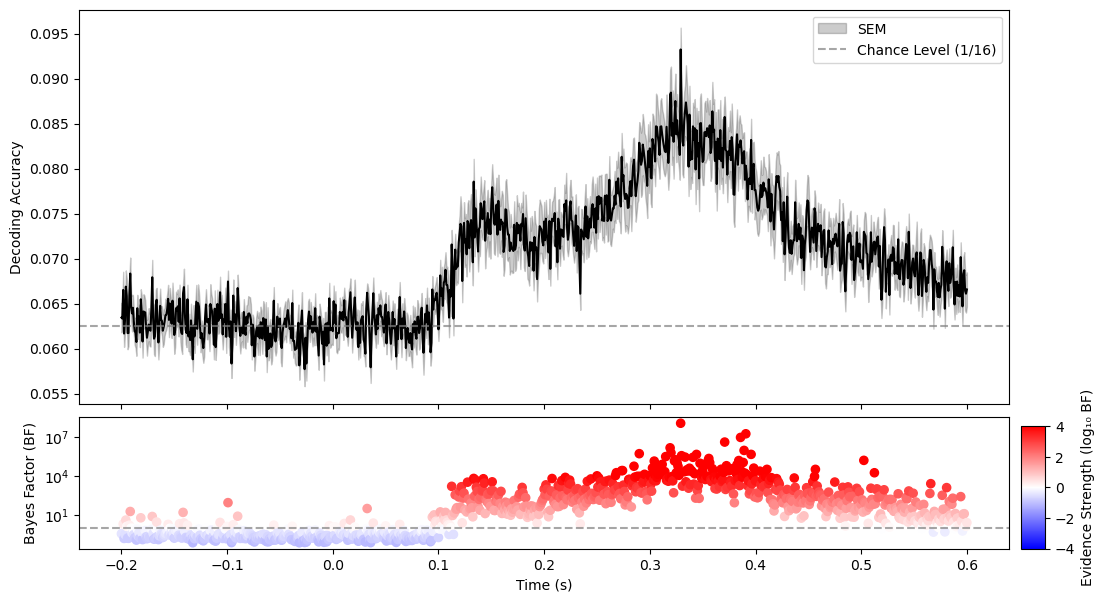

In [7]:
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#Library path to r (will need to be adjusted for a given environment)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)
#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # <-- wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)

bf_line = compute_bayes_factors_group(all_subjects_line2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

log_bf = np.log10(bf_line)
times = np.load('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy')

# Colormap setup
cmap = cm.get_cmap('bwr')
max_abs_logbf = 4
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_logbf, vcenter=0, vmax=max_abs_logbf)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

sem_scores = all_subjects_line2.std(axis=0) / np.sqrt(all_subjects_line2.shape[0])
# Top plot: mean decoding accuracy
ax1.plot(times, all_subjects_line2.mean(axis=0), color='black')
ax1.fill_between(times, all_subjects_line2.mean(axis=0) - sem_scores, all_subjects_line2.mean(axis=0) + sem_scores,
                 color='black', alpha=0.2, label='SEM')
ax1.axhline(y=1/16, color='gray', linestyle='--', label='Chance Level (1/16)', alpha=.7)
ax1.set_ylabel('Decoding Accuracy')
ax1.legend(loc='upper right')

# Bottom plot: Bayes Factor dots
sc = ax2.scatter(times, bf_line, c=log_bf, cmap=cmap, norm=norm, s=35)
ax2.set_yscale('log')
ax2.set_ylabel('Bayes Factor (BF)')
ax2.axhline(y=1, color='gray', linestyle='--', label='BF = 1', alpha=.7)
ax2.set_xlabel('Time (s)')  # x-axis now in seconds




# Colorbar
pos = ax2.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
sc.set_clim(-max_abs_logbf, max_abs_logbf)
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Evidence Strength (log₁₀ BF)')

plt.subplots_adjust(hspace=0.05)
save_path = os.path.join(output_dir, 'Group_Mean_Scores_and_BayesFactors.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()


In [20]:
print(all_subjects_line.shape)

(20, 961)


 R packages loaded successfully.


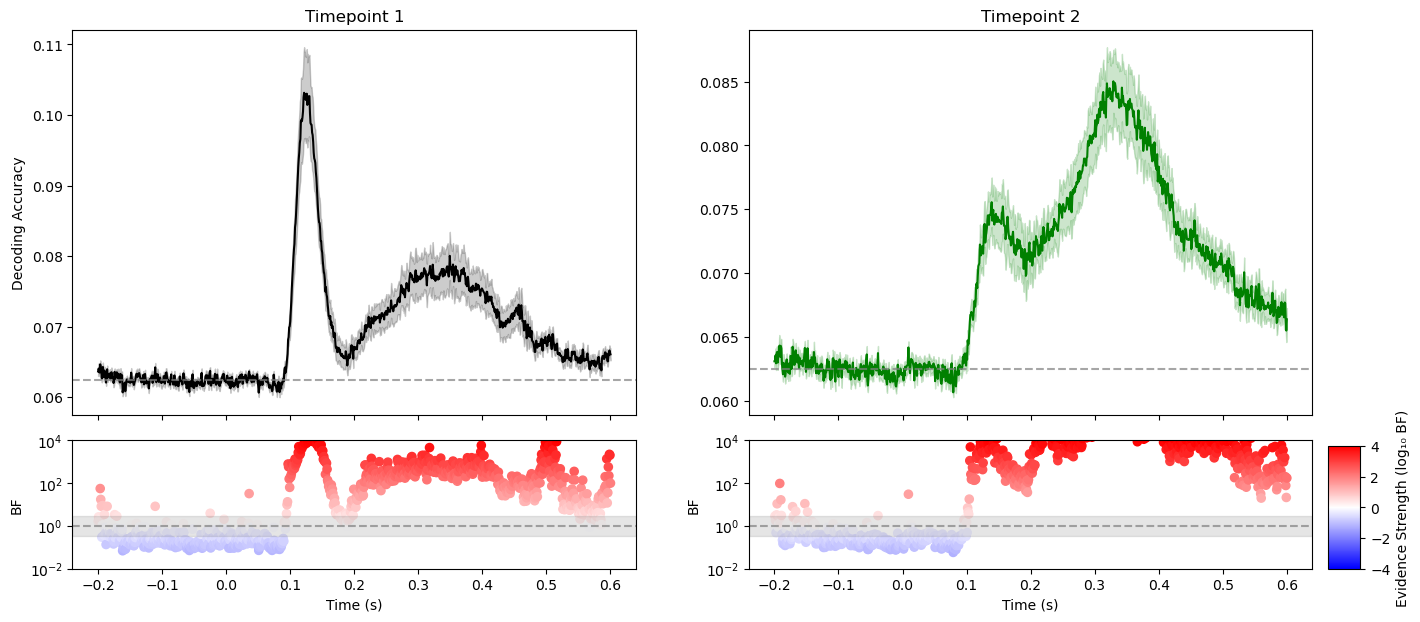

In [34]:
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#Library path to r (will need to be adjusted for a given environment)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)
#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # <-- wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)
window_size = 36
half_window = window_size // 2

def extract_window_mean(subj, tp):
    data = np.load(os.path.join(base_path, f"{subj}_trainTime_data.npy"))
    start = max(0, tp - half_window)
    end = min(data.shape[0], tp + half_window)
    return data[start:end, :].mean(axis=0)  # mean across training-time window

all_subjects_line = np.array([extract_window_mean(subj, time1_idx) for subj in subject_ids])
all_subjects_line2 = np.array([extract_window_mean(subj, time2_idx) for subj in subject_ids])

# Compute Bayes factors
bf_line = compute_bayes_factors_group(all_subjects_line)
bf_line2 = compute_bayes_factors_group(all_subjects_line2)
log_bf = np.log10(bf_line)
log_bf2 = np.log10(bf_line2)

# --- Plotting ---
fig, axes = plt.subplots(
    2, 2, figsize=(16, 7),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex='col'
)
ax1, ax2 = axes[0]  # top row: decoding
ax3, ax4 = axes[1]  # bottom row: Bayes factors

# --- Top row: decoding accuracy ---
sem_scores1 = all_subjects_line.std(axis=0) / np.sqrt(all_subjects_line.shape[0])
ax1.plot(times, all_subjects_line.mean(axis=0), color='black')
ax1.fill_between(times,
                 all_subjects_line.mean(axis=0) - sem_scores1,
                 all_subjects_line.mean(axis=0) + sem_scores1,
                 color='black', alpha=0.2)
ax1.axhline(y=1/16, color='gray', linestyle='--', alpha=.7)
ax1.set_ylabel('Decoding Accuracy')
ax1.set_title('Timepoint 1')

sem_scores2 = all_subjects_line2.std(axis=0) / np.sqrt(all_subjects_line2.shape[0])
ax2.plot(times, all_subjects_line2.mean(axis=0), color='green')
ax2.fill_between(times,
                 all_subjects_line2.mean(axis=0) - sem_scores2,
                 all_subjects_line2.mean(axis=0) + sem_scores2,
                 color='green', alpha=0.2)
ax2.axhline(y=1/16, color='gray', linestyle='--', alpha=.7)
ax2.set_title('Timepoint 2')

# --- Bottom row: Bayes factors ---
sc1 = ax3.scatter(times, bf_line, c=log_bf, cmap=cmap, norm=norm, s=35)
ax3.set_yscale('log')
ax3.set_ylabel('BF')
ax3.axhline(1, color='gray', linestyle='--', alpha=.7)
ax3.axhspan(1/3, 3, color='gray', alpha=0.2)
ax3.set_ylim(1e-2, 1e4)
ax3.set_xlabel('Time (s)')

sc2 = ax4.scatter(times, bf_line2, c=log_bf2, cmap=cmap, norm=norm, s=35)
ax4.set_yscale('log')
ax4.set_ylabel('BF')
ax4.axhline(1, color='gray', linestyle='--', alpha=.7)
ax4.axhspan(1/3, 3, color='gray', alpha=0.2)
ax4.set_ylim(1e-2, 1e4)
ax4.set_xlabel('Time (s)')

# --- Colorbar for BF subplot (match ax4 height) ---
pos = ax4.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='vertical')
cbar.set_label('Evidence Strength (log₁₀ BF)')

plt.subplots_adjust(wspace=0.2, hspace=0.1)
save_path = os.path.join(output_dir, 'EXCLud9.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

